# Lab 1 Task 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary
from tqdm import tqdm

In [2]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [3]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

[0.49140018 0.48215762 0.44652876] [0.24703316 0.24348514 0.26158804]
[0.49140018 0.48215762 0.44652876] [0.24703316 0.24348514 0.26158804]


In [4]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    # 同學實作部分：Add data augmentation here
    transforms.RandomRotation(15,expand = True),
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    
    transforms.ToTensor(), # Transform to tensor
    transforms.Normalize(mean=train_mean, std=train_std), # Normalization
])

transform_test = transforms.Compose([
    transforms.RandomRotation(15,expand = True),
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [5]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

image shape:  torch.Size([3, 224, 224])
train length:  45000
val length:  5000
test length:  10000


In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion: int = 1, downsample: nn.Module = None,):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)



    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 學生實作部分：Define the ResNet-18 architecture using BasicBlock
        layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 學生實作部分：Define make_layer function to create layers of blocks
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_blocks):
            layers.append(
                block(self.in_channels, out_channels, expansion=self.expansion)
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        # 學生實作部分：Define the forward pass of ResNet-18
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)

        return out

In [7]:
# Create SummaryWriter
writer = SummaryWriter("./tensorboard")

model = ResNet18(num_classes=10)
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
# Print model summary
summary(model, input_size=(3, 224, 224))

# Calculate FLOPs and Params
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1

In [8]:
# Setting parameter
EPOCH = 40
pre_epoch = 0
lr = 0.01

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

best_model_path = 'best_resnet18.pth'
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded model weights from {best_model_path}")
else:
    print("No saved model found, starting from scratch.")

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # 學生實作部分：Complete the training and validation loop
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch+1))

    # train the model
    model.train()
    train_correct = 0
    train_total = 0
    for data, target in tqdm(trainloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # update training Accuracy
        train_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()

    scheduler.step()


    # validate the model
    model.eval()
    valid_correct = 0
    valid_total = 0
    for data, target in tqdm(validloader):
        # move tensors to GPU if CUDA is available
        target = target.long()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        valid_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    train_acc = 100 * train_correct / train_total
    val_acc = 100 * valid_correct / valid_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracies.append(val_acc)
    
    
    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("saving model...")


    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {valid_loss:.4f} | Val Acc: {val_acc:.2f}%")


No saved model found, starting from scratch.
running epoch: 1


100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


saving model...
Epoch [1/40] Train Loss: 1.8437 | Train Acc: 31.32% | Val Loss: 1.5874 | Val Acc: 40.46%
running epoch: 2


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


saving model...
Epoch [2/40] Train Loss: 1.4787 | Train Acc: 45.81% | Val Loss: 1.4673 | Val Acc: 46.60%
running epoch: 3


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


saving model...
Epoch [3/40] Train Loss: 1.2642 | Train Acc: 54.14% | Val Loss: 1.2950 | Val Acc: 53.28%
running epoch: 4


100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


saving model...
Epoch [4/40] Train Loss: 1.0996 | Train Acc: 60.47% | Val Loss: 1.0735 | Val Acc: 61.22%
running epoch: 5


100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


saving model...
Epoch [5/40] Train Loss: 1.0214 | Train Acc: 63.33% | Val Loss: 1.0137 | Val Acc: 63.68%
running epoch: 6


100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


saving model...
Epoch [6/40] Train Loss: 0.9600 | Train Acc: 65.84% | Val Loss: 0.9601 | Val Acc: 65.94%
running epoch: 7


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


saving model...
Epoch [7/40] Train Loss: 0.8653 | Train Acc: 69.33% | Val Loss: 0.9230 | Val Acc: 67.62%
running epoch: 8


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


saving model...
Epoch [8/40] Train Loss: 0.8234 | Train Acc: 70.66% | Val Loss: 0.8548 | Val Acc: 69.68%
running epoch: 9


100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch [9/40] Train Loss: 0.7883 | Train Acc: 72.01% | Val Loss: 0.8684 | Val Acc: 69.08%
running epoch: 10


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


saving model...
Epoch [10/40] Train Loss: 0.7223 | Train Acc: 74.42% | Val Loss: 0.7470 | Val Acc: 73.44%
running epoch: 11


100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


saving model...
Epoch [11/40] Train Loss: 0.6952 | Train Acc: 75.45% | Val Loss: 0.7455 | Val Acc: 74.00%
running epoch: 12


100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


saving model...
Epoch [12/40] Train Loss: 0.6708 | Train Acc: 76.19% | Val Loss: 0.7078 | Val Acc: 76.16%
running epoch: 13


100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


saving model...
Epoch [13/40] Train Loss: 0.6177 | Train Acc: 78.23% | Val Loss: 0.6615 | Val Acc: 76.22%
running epoch: 14


100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


saving model...
Epoch [14/40] Train Loss: 0.6065 | Train Acc: 78.71% | Val Loss: 0.6628 | Val Acc: 77.10%
running epoch: 15


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Epoch [15/40] Train Loss: 0.5858 | Train Acc: 79.27% | Val Loss: 0.6378 | Val Acc: 77.00%
running epoch: 16


100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


saving model...
Epoch [16/40] Train Loss: 0.5479 | Train Acc: 80.62% | Val Loss: 0.5793 | Val Acc: 79.44%
running epoch: 17


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


saving model...
Epoch [17/40] Train Loss: 0.5247 | Train Acc: 81.40% | Val Loss: 0.5579 | Val Acc: 80.32%
running epoch: 18


100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Epoch [18/40] Train Loss: 0.5139 | Train Acc: 81.89% | Val Loss: 0.5823 | Val Acc: 79.10%
running epoch: 19


100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


saving model...
Epoch [19/40] Train Loss: 0.4863 | Train Acc: 82.85% | Val Loss: 0.5445 | Val Acc: 81.12%
running epoch: 20


100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


saving model...
Epoch [20/40] Train Loss: 0.4760 | Train Acc: 83.40% | Val Loss: 0.5285 | Val Acc: 81.34%
running epoch: 21


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Epoch [21/40] Train Loss: 0.4635 | Train Acc: 83.63% | Val Loss: 0.5479 | Val Acc: 80.76%
running epoch: 22


100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


saving model...
Epoch [22/40] Train Loss: 0.4334 | Train Acc: 84.62% | Val Loss: 0.5005 | Val Acc: 82.76%
running epoch: 23


100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Epoch [23/40] Train Loss: 0.4274 | Train Acc: 84.92% | Val Loss: 0.4981 | Val Acc: 82.56%
running epoch: 24


100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


saving model...
Epoch [24/40] Train Loss: 0.4188 | Train Acc: 85.18% | Val Loss: 0.4900 | Val Acc: 82.78%
running epoch: 25


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


Epoch [25/40] Train Loss: 0.4012 | Train Acc: 85.80% | Val Loss: 0.4904 | Val Acc: 82.66%
running epoch: 26


100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


saving model...
Epoch [26/40] Train Loss: 0.3923 | Train Acc: 86.15% | Val Loss: 0.4789 | Val Acc: 83.32%
running epoch: 27


100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


saving model...
Epoch [27/40] Train Loss: 0.3867 | Train Acc: 86.31% | Val Loss: 0.4704 | Val Acc: 83.80%
running epoch: 28


100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Epoch [28/40] Train Loss: 0.3677 | Train Acc: 86.85% | Val Loss: 0.4596 | Val Acc: 83.64%
running epoch: 29


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Epoch [29/40] Train Loss: 0.3632 | Train Acc: 87.24% | Val Loss: 0.4549 | Val Acc: 83.80%
running epoch: 30


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


saving model...
Epoch [30/40] Train Loss: 0.3627 | Train Acc: 87.29% | Val Loss: 0.4603 | Val Acc: 83.92%
running epoch: 31


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


saving model...
Epoch [31/40] Train Loss: 0.3480 | Train Acc: 87.76% | Val Loss: 0.4455 | Val Acc: 84.70%
running epoch: 32


100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


saving model...
Epoch [32/40] Train Loss: 0.3403 | Train Acc: 88.11% | Val Loss: 0.4441 | Val Acc: 84.86%
running epoch: 33


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch [33/40] Train Loss: 0.3380 | Train Acc: 88.19% | Val Loss: 0.4487 | Val Acc: 84.84%
running epoch: 34


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


Epoch [34/40] Train Loss: 0.3292 | Train Acc: 88.44% | Val Loss: 0.4296 | Val Acc: 84.80%
running epoch: 35


100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


saving model...
Epoch [35/40] Train Loss: 0.3277 | Train Acc: 88.50% | Val Loss: 0.4235 | Val Acc: 85.38%
running epoch: 36


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Epoch [36/40] Train Loss: 0.3216 | Train Acc: 88.66% | Val Loss: 0.4389 | Val Acc: 84.92%
running epoch: 37


100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Epoch [37/40] Train Loss: 0.3158 | Train Acc: 88.89% | Val Loss: 0.4300 | Val Acc: 84.78%
running epoch: 38


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Epoch [38/40] Train Loss: 0.3167 | Train Acc: 88.77% | Val Loss: 0.4230 | Val Acc: 85.12%
running epoch: 39


100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


saving model...
Epoch [39/40] Train Loss: 0.3115 | Train Acc: 89.02% | Val Loss: 0.4233 | Val Acc: 85.46%
running epoch: 40


100%|██████████| 20/20 [00:02<00:00,  8.19it/s]

Epoch [40/40] Train Loss: 0.3071 | Train Acc: 89.22% | Val Loss: 0.4341 | Val Acc: 85.06%


In [9]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")

Best Model Test Accuracy: 85.04%


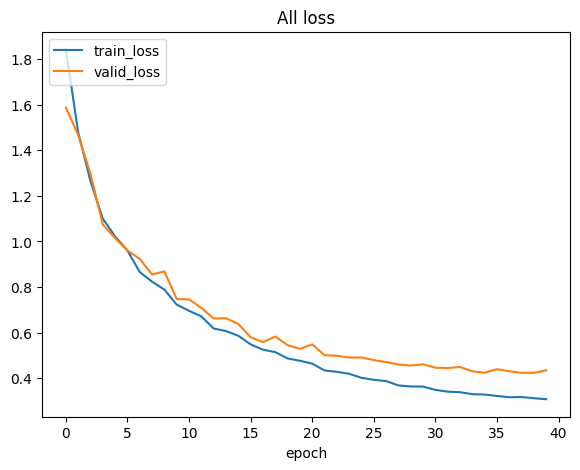

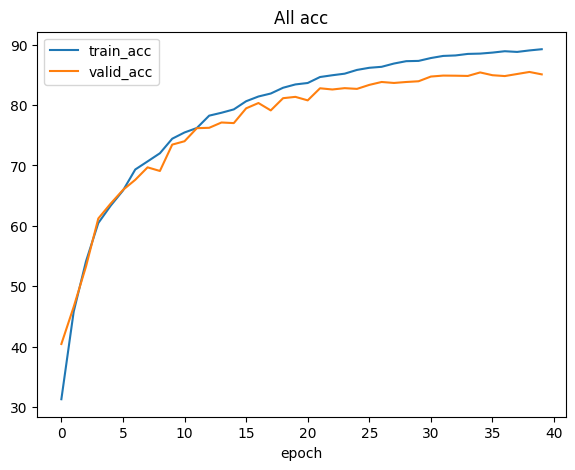

In [10]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
# 學生實作部分：Plot training and validation loss and accuracy curves
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_accuracies)
    ax1.plot(val_accuracies)

    ax1.legend(['train_acc', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_losses)
    ax1.plot(val_losses)

    ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()